# Calibration of a detector on a translation table

The aim of this document is to explain how to use pyFAI.goniometer for calibrating the position detector from the translation table encoders.

Those data have been acquired at ESRF-ID29 in summer 2013 on a Pilatus 6M using Ceria (CeO2) as calibrant.
Seven images have been acquired with the detector moved between 15 cm and 45 cm from the sample position.
A prior calibration has been performed using the *MX-calibrate* script from the pyFAI suite. 
The control points extracted during this initial calibration have been used as a starting point for this calibration.

The raw data files are available at:
http://www.silx.org/pub/pyFAI/gonio/MX-ceria/

In [1]:
# Initialization of the plotting library for use in the Jupyter notebook

%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading of a few libraries

import time
start_time =time.time()
import os
import fabio
import pyFAI
from  pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

In [3]:
#Download all images
#Specific at ESRF
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"
from silx.resources import ExternalResources
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages", "PYFAI_DATA")
all_files = downloader.getdir("MX_ceria.tar.bz2")
print(all_files)


['/tmp/pyFAI_testdata_kieffer/MX_ceria', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_300_1_0001.npt', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001.cbf', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_200_1_0001.npt', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001.cbf', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001.npt', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_400_1_0001.cbf', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_400_1_0001.npt', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_450_1_0001.cbf', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001.npt', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_200_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_350_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_300_1_0001.cbf', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_450_1_0001.npt', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ce

List of images: /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001.cbf, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_200_1_0001.cbf, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001.cbf, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_300_1_0001.cbf, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_350_1_0001.cbf, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_400_1_0001.cbf, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_450_1_0001.cbf.

Image headers:
_array_data.header_contents: # Detector: PILATUS 6M, S/N 60-0104, ESRF ID29
# 2013/Aug/29 17:26:59.699
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000320 m
# Start_angle 0.000000 deg.
# Exposure_time 0.037000 s
# Exposure_period 0.040000 s
# Tau = 0 s
# Count_cutoff 1048500
# Threshold_setting 7612 eV
# N_excluded_pixels = 321
# Excluded_pixels:  badpix_mask.tif
# Flat_field:  (nil)
# Trim_directory: (nil)
# Wavelength 0.972386 A
# Detector_distance 0.150000 m
# Energy_range (0, 0) eV
# Detector_Voffset 0.0000 m
# Beam_xy (1230.90

<IPython.core.display.Javascript object>


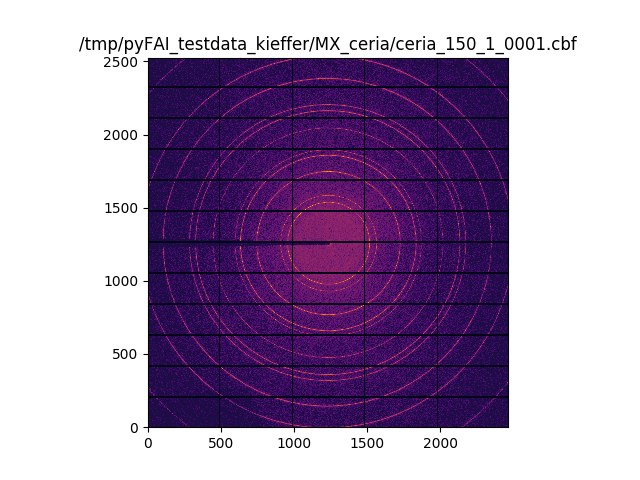

In [4]:
# Loading of the list of files, and display of the first one with its headers

image_files = [i for i in all_files if i.endswith(".cbf")]
image_files.sort()
print("List of images: " + ", ".join(image_files) + "." + os.linesep)
fimg = fabio.open(image_files[0])

print("Image headers:")
for key, value in  fimg.header.items():
    print("%s: %s"%(key,value))
    
jupyter.display(fimg.data, label=fimg.filename)

In [5]:
# Definition of the geometry translation function:

geotrans = GeometryTransformation(param_names = ["dist_offset", "dist_scale", 
                                                 "poni1", "poni2", "rot1","rot2"],
                                  dist_expr="pos * dist_scale + dist_offset", 
                                  poni1_expr="poni1",
                                  poni2_expr="poni2", 
                                  rot1_expr="rot1", 
                                  rot2_expr="rot2", 
                                  rot3_expr="0.0")


# Definition of the function reading the detector position from the header of the image.

def get_distance(header):
    """Takes the header of the CBF-file and returns the distance of the detector"""
    dist = 0
    for line in header.get("_array_data.header_contents","").split("\n"):
        words = line.split()
        if words[1] == "Detector_distance":
            dist = float(words[2])
            break
    return dist

print("Distance:",get_distance(fimg.header))

Distance: 0.15


In [6]:
# Definition of the detector, the calibrant and extraction of the wavelength used from the headers

pilatus = pyFAI.detector_factory("Pilatus6M")
CeO2 = pyFAI.calibrant.get_calibrant("CeO2")
for line in fimg.header.get("_array_data.header_contents","").split("\n"):
    words = line.split()
    if words[1] == "Wavelength":
        wavelength = float(words[2])*1e-10
        break
print("Wavelength:", wavelength)
CeO2.wavelength = wavelength
print(CeO2)

Wavelength: 9.72386e-11
CeO2 Calibrant at wavelength 9.72386e-11


In [7]:
# Definition of the geometry refinement: the parameter order is the same as the param_names

param = {"dist_offset":0, 
         "dist_scale":1,
         "poni1":0.2, 
         "poni2":0.2, 
         "rot1":0,
         "rot2":0}

gonioref = GoniometerRefinement(param, #initial guess
                                pos_function=get_distance,
                                trans_function=geotrans,
                                detector=pilatus,
                                wavelength=wavelength)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [8]:
# Let's populate the goniometer refinement object with all control point files:

ponis = [i for i in all_files if i.endswith(".poni")]
ponis.sort()
print(ponis)
for fn in ponis:
    base = os.path.splitext(fn)[0]
    fimg = fabio.open(base + ".cbf")
    gonioref.new_geometry(base, image=fimg.data, metadata=fimg.header, control_points=base+".npt",
                          geometry=fn, calibrant=CeO2)

print("Filled refinement object:")
print(gonioref)
print(os.linesep+"\tLabel \t Distance")
for k, v in gonioref.single_geometries.items():
    print(k,v.get_position())

['/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_200_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_300_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_350_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_400_1_0001.poni', '/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_450_1_0001.poni']
Filled refinement object:
GoniometerRefinement with 7 geometries labeled: /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_200_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_300_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_350_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_400_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_450_1_0001.

	Label 	 Distance
/tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001 0.15
/tmp/pyFAI_testdata_kieffer/

<IPython.core.display.Javascript object>


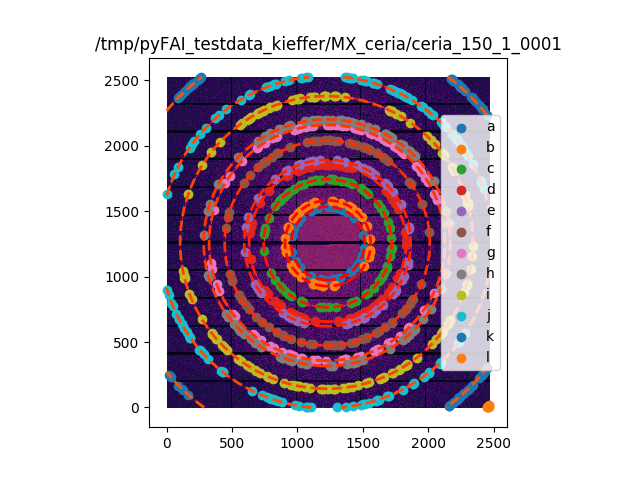

<IPython.core.display.Javascript object>


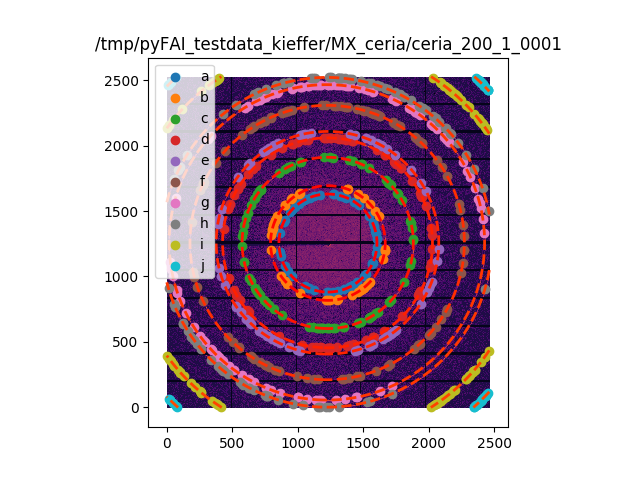

<IPython.core.display.Javascript object>


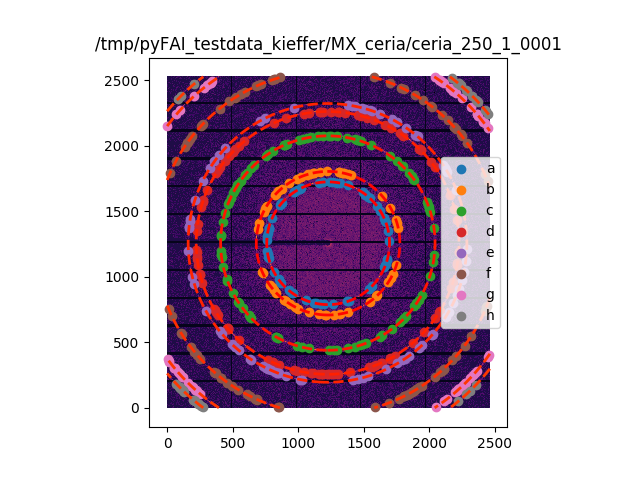

<IPython.core.display.Javascript object>


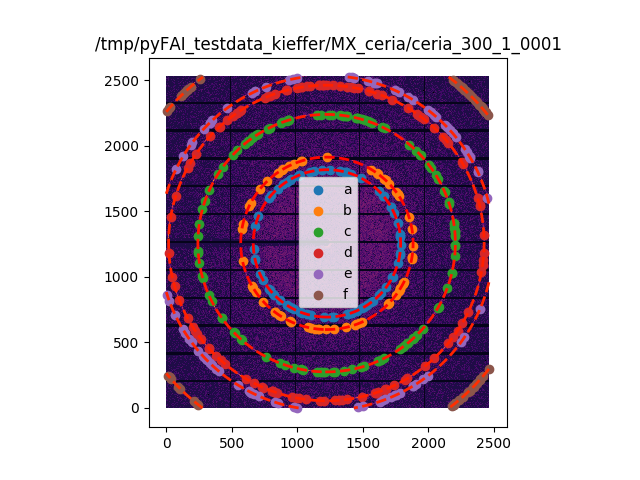

<IPython.core.display.Javascript object>


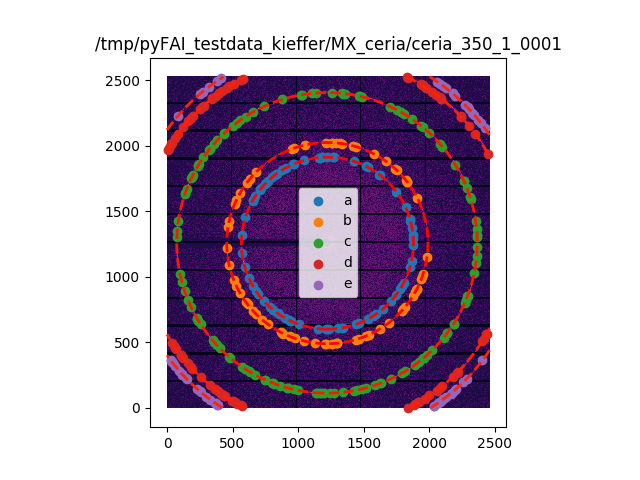

<IPython.core.display.Javascript object>


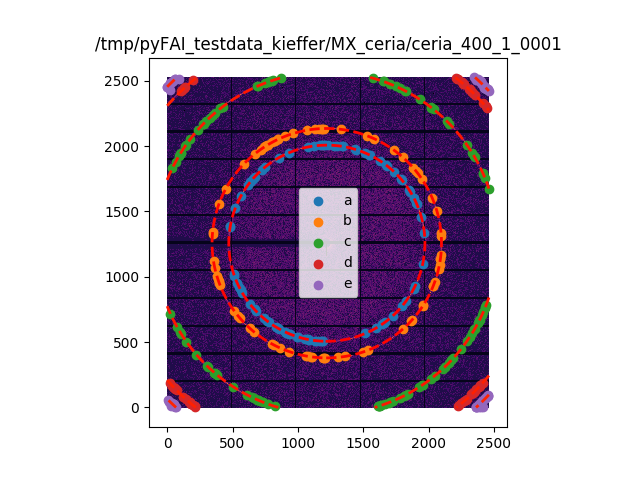

<IPython.core.display.Javascript object>


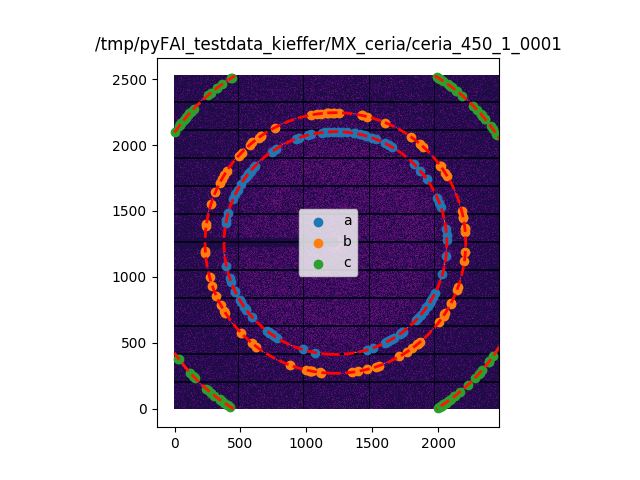

In [9]:
# Display all images with associated calibration:

for sg in gonioref.single_geometries.values():
    jupyter.display(sg=sg)

In [10]:
# Initial refinement of the translation table model

gonioref.refine2()

Cost function before refinement: 0.00166968476865
     fun: 5.119380332306429e-07
     jac: array([  1.15391165e-06,   3.42232646e-07,   8.12183671e-08,
         5.02958173e-08,  -7.17337869e-08,  -1.11380615e-07])
 message: 'Optimization terminated successfully.'
    nfev: 148
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([-0.00118793,  1.00190471,  0.21548514,  0.21309905,  0.00661241,
        0.00280329])
Cost function after refinement: 5.119380332306429e-07
GonioParam(dist_offset=-0.0011879346142064896, dist_scale=1.0019047068993876, poni1=0.21548513632380822, poni2=0.21309905129447423, rot1=0.0066124085461557701, rot2=0.0028032884844600525)
maxdelta on: poni1 (2) 0.2 --> 0.215485136324


array([-0.00118793,  1.00190471,  0.21548514,  0.21309905,  0.00661241,
        0.00280329])

In [11]:
# Save the result of the fitting to a file and display the content of the JSON file:

gonioref.save("ID29.json")
with open("ID29.json") as fd:
    print(fd.read())

{
  "content": "Goniometer calibration v1.0",
  "detector": "Pilatus 6M",
  "pixel1": 0.000172,
  "pixel2": 0.000172,
  "wavelength": 9.72386e-11,
  "param": [
    -0.0011879346142064896,
    1.0019047068993876,
    0.21548513632380822,
    0.21309905129447423,
    0.00661240854615577,
    0.0028032884844600525
  ],
  "param_names": [
    "dist_offset",
    "dist_scale",
    "poni1",
    "poni2",
    "rot1",
    "rot2"
  ],
  "pos_names": [
    "pos"
  ],
  "trans_function": {
    "content": "GeometryTransformation",
    "param_names": [
      "dist_offset",
      "dist_scale",
      "poni1",
      "poni2",
      "rot1",
      "rot2"
    ],
    "pos_names": [
      "pos"
    ],
    "dist_expr": "pos * dist_scale + dist_offset",
    "poni1_expr": "poni1",
    "poni2_expr": "poni2",
    "rot1_expr": "rot1",
    "rot2_expr": "rot2",
    "rot3_expr": "0.0",
    "constants": {
      "pi": 3.141592653589793
    }
  }
}


In [12]:
# Restore the translation table setting from the file

transtable = Goniometer.sload("ID29.json")
print("Translation table: \n",transtable)

Translation table: 
 Goniometer with param GonioParam(dist_offset=-0.0011879346142064896, dist_scale=1.0019047068993876, poni1=0.21548513632380822, poni2=0.21309905129447423, rot1=0.00661240854615577, rot2=0.0028032884844600525)    
 with Detector Pilatus 6M	 PixelSize= 1.720e-04, 1.720e-04 m


In [13]:
# Create a multi-geometry object for all images in this set:

distances = [get_distance(fabio.open(fn).header) for fn in image_files]
print("Distances: ", distances)
multigeo = transtable.get_mg(distances)
multigeo.radial_range=(0, 65)
print(multigeo)

Distances:  [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
MultiGeometry integrator with 7 geometries on (0, 65) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


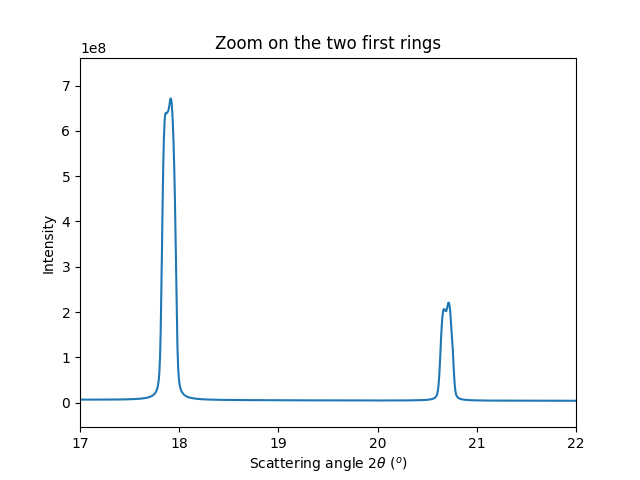

In [14]:
# Integrate the set of images in a single run:

res = multigeo.integrate1d([fabio.open(fn).data for fn in image_files], 10000)

# Display the result using matplotlib
fig, ax = subplots()
ax.plot(*res)
ax.set_xlabel(res.unit.label)
ax.set_ylabel("Intensity")
ax.set_xlim(17, 22)
ax.set_title("Zoom on the two first rings")

Accoring to the provious image, peaks look double which indicates a bad modeling of the setup or a bad fitting.
As the fitting ended successfully, the bug is likely in the model: let's allow the PONI to move with the distance

In [15]:
# Let's refine poni1 and poni2 also as function of the distance:

geotrans2 = GeometryTransformation(param_names = ["dist_offset", "dist_scale", 
                                                  "poni1_offset", "poni1_scale",
                                                  "poni2_offset", "poni2_scale",
                                                  "rot1","rot2"],
                         dist_expr="pos * dist_scale + dist_offset", 
                         poni1_expr="pos * poni1_scale + poni1_offset",
                         poni2_expr="pos * poni2_scale + poni2_offset", 
                         rot1_expr="rot1", 
                         rot2_expr="rot2", 
                         rot3_expr="0.0")

#initial guess from former parameter set
param2 = (gonioref.nt_param(*gonioref.param))._asdict()
param2["poni1_offset"] = 0
param2["poni2_offset"] = 0
param2["poni1_scale"] = 1
param2["poni2_scale"] = 1

gonioref2 = GoniometerRefinement(param2, 
                                 pos_function = get_distance,
                                 trans_function=geotrans2,
                                 detector=pilatus,
                                 wavelength=wavelength)
gonioref2.single_geometries = gonioref.single_geometries.copy()
print(gonioref2)


GoniometerRefinement with 7 geometries labeled: /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_150_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_200_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_250_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_300_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_350_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_400_1_0001, /tmp/pyFAI_testdata_kieffer/MX_ceria/ceria_450_1_0001.


In [16]:
# Refinement of the second model with all distances free

gonioref2.refine2()

Cost function before refinement: 0.0436448742052
     fun: 1.621998573406867e-07
     jac: array([  5.32202929e-07,   8.74258230e-08,   1.65541298e-07,
         1.80205095e-08,  -2.92970160e-07,  -7.38347143e-08,
         8.45047090e-08,  -1.73614865e-08])
 message: 'Optimization terminated successfully.'
    nfev: 344
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([-0.00118686,  1.00184287,  0.21574533, -0.00429667,  0.21300993,
        0.00138094,  0.00735187,  0.00492121])
Cost function after refinement: 1.621998573406867e-07
GonioParam(dist_offset=-0.0011868649111587623, dist_scale=1.001842873704045, poni1_offset=0.21574533062964613, poni1_scale=-0.0042966738927481124, poni2_offset=0.21300993413748515, poni2_scale=0.0013809412109975984, rot1=0.0073518675577171084, rot2=0.0049212066470728684)
maxdelta on: poni1_scale (3) 1 --> -0.00429667389275


array([-0.00118686,  1.00184287,  0.21574533, -0.00429667,  0.21300993,
        0.00138094,  0.00735187,  0.00492121])

MultiGeometry integrator with 7 geometries on (0, 65) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


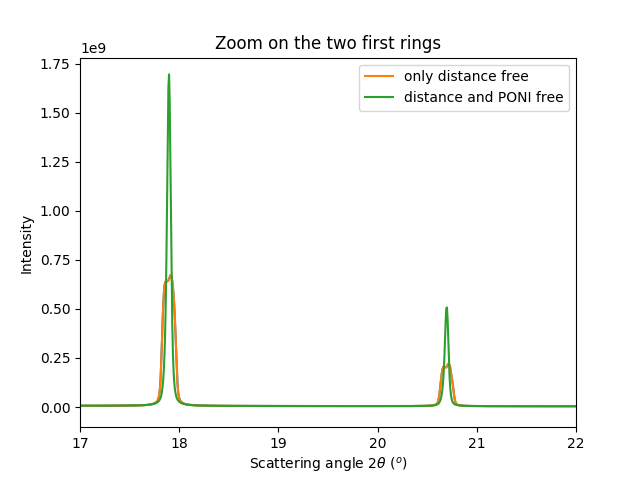

In [17]:
# Integration of all images with the second model

multigeo2 = gonioref2.get_mg(distances)
multigeo2.radial_range=(0, 65)
print(multigeo2)
res2 = multigeo2.integrate1d([fabio.open(fn).data for fn in image_files], 10000)

# Display the result, zooming on the two first rings
fig, ax = subplots()
ax.plot(*res)
ax.plot(*res, label="only distance free")
ax.plot(*res2, label="distance and PONI free")
ax.set_ylabel("Intensity")
ax.set_xlim(17, 22)
ax.set_title("Zoom on the two first rings")
ax.set_xlabel(res2.unit.label)
ax.legend()

<IPython.core.display.Javascript object>


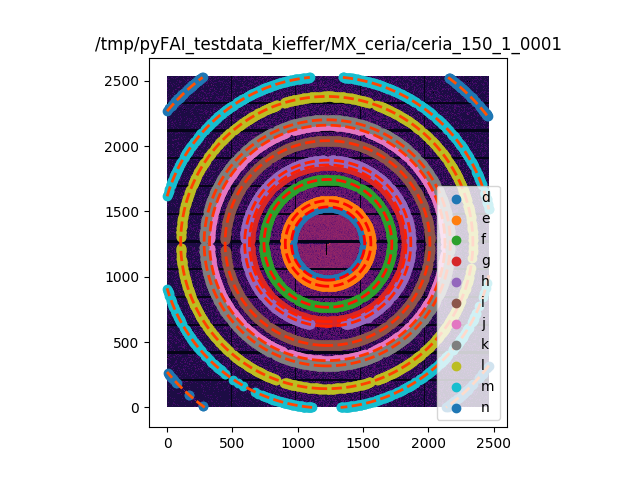

<IPython.core.display.Javascript object>


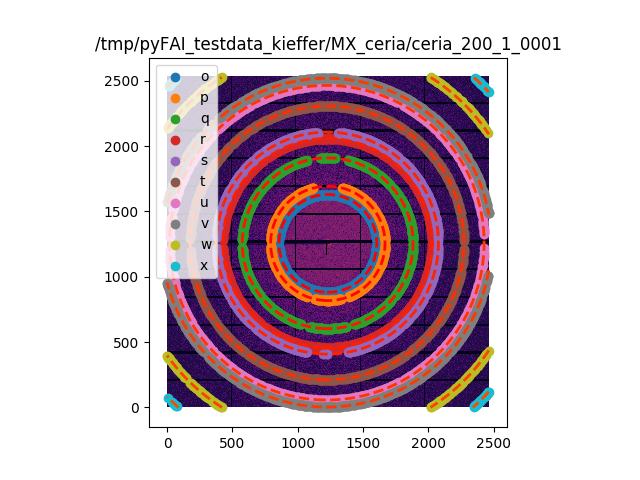

<IPython.core.display.Javascript object>


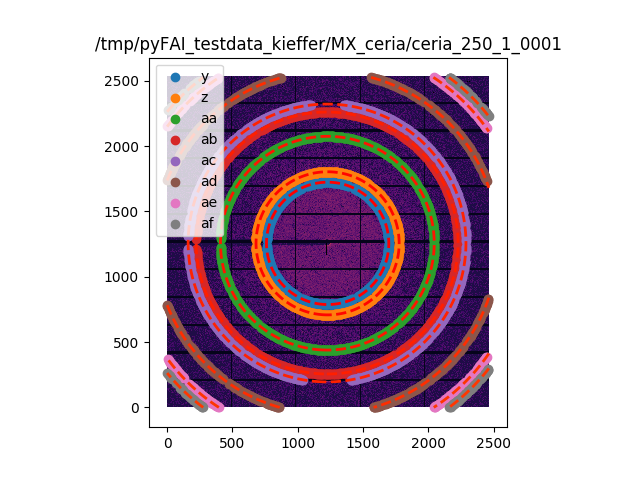

<IPython.core.display.Javascript object>


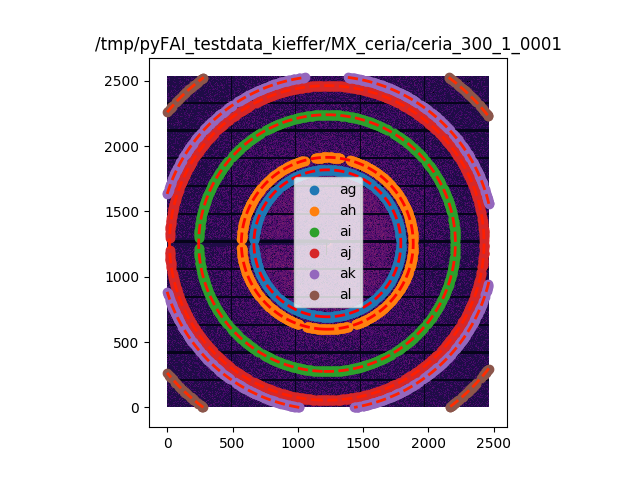

<IPython.core.display.Javascript object>


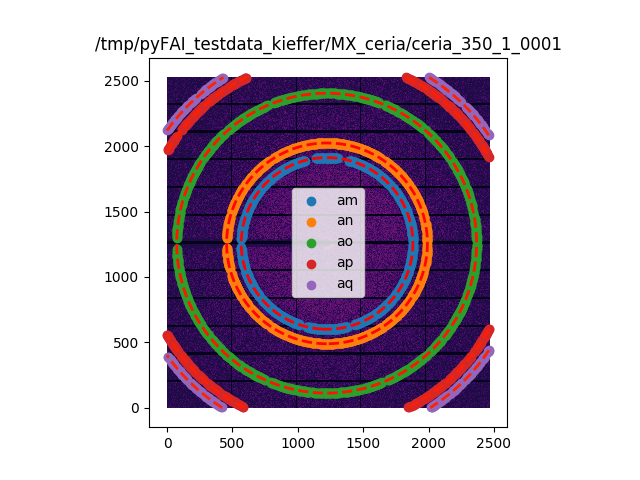

<IPython.core.display.Javascript object>


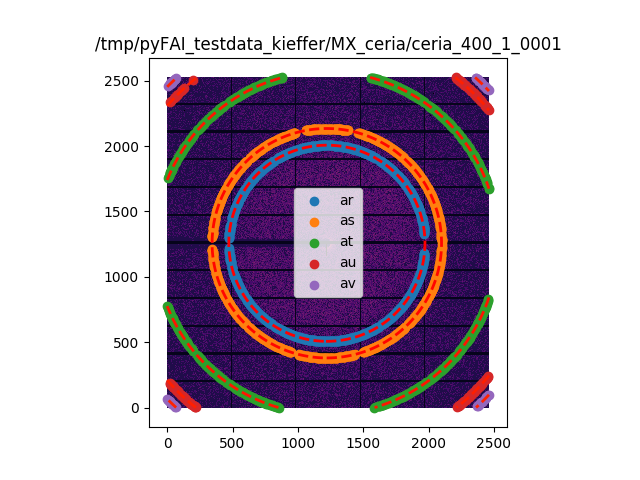

<IPython.core.display.Javascript object>


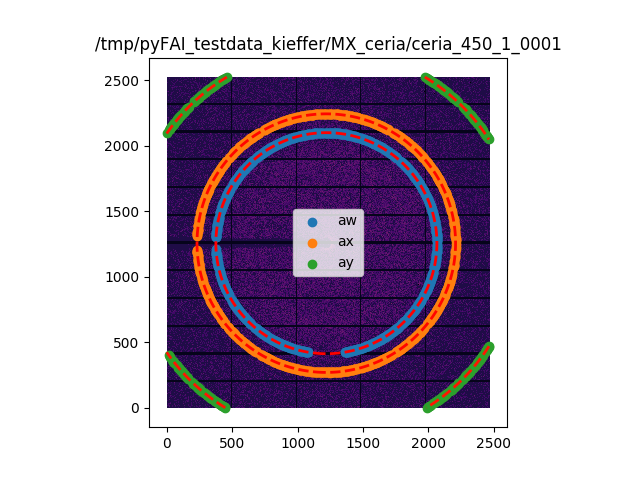

In [18]:
# Re-extract many more control points from images for a better fit

for sg in gonioref2.single_geometries.values():
    sg.extract_cp(pts_per_deg=3)
    jupyter.display(sg=sg)

Cost function before refinement: 5.40255617283e-08
     fun: 5.0213142704005095e-08
     jac: array([ -1.43919725e-08,  -9.98079623e-08,   7.11607662e-08,
         1.72619064e-07,  -4.82523451e-07,   2.80753421e-08,
         6.28126328e-07,  -3.03749976e-07])
 message: 'Optimization terminated successfully.'
    nfev: 113
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([-0.00120787,  1.00182298,  0.21574401, -0.0041032 ,  0.21301432,
        0.0012476 ,  0.00726519,  0.00480541])
Cost function after refinement: 5.0213142704005095e-08
GonioParam(dist_offset=-0.0012078678076421403, dist_scale=1.0018229750136767, poni1_offset=0.21574400641820235, poni1_scale=-0.0041031981415808379, poni2_offset=0.21301431754420563, poni2_scale=0.001247597331754629, rot1=0.0072651876931131652, rot2=0.0048054104396993242)
maxdelta on: poni1_scale (3) -0.00429667389275 --> -0.00410319814158
MultiGeometry integrator with 7 geometries on (0, 65) radial range (2th_deg) and (-180, 180) azimu

<IPython.core.display.Javascript object>


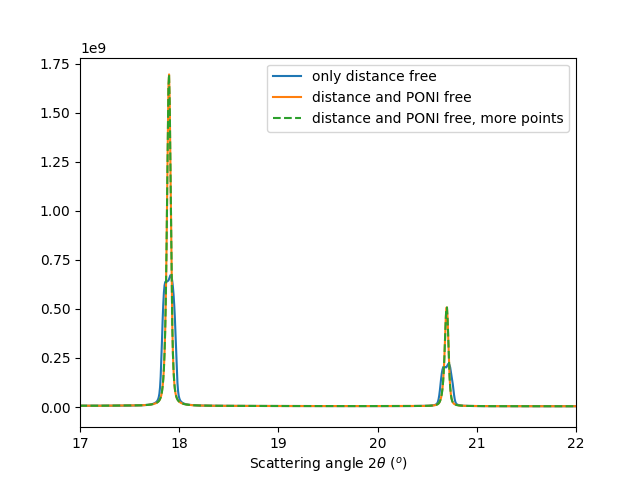

In [19]:
# Refine again the model

gonioref2.refine2()

# Build the MultiGeometry integrator object

multigeo3 = gonioref2.get_mg(distances)
multigeo3.radial_range=(0, 65)
print(multigeo3)

# Perform the azimuthal integration
res3 = multigeo3.integrate1d([fabio.open(fn).data for fn in image_files], 10000)

# Display the result
fig, ax = subplots()
ax.plot(*res, label="only distance free")
ax.plot(*res2, label="distance and PONI free")
ax.plot(*res2, linestyle="--", label="distance and PONI free, more points")
ax.set_xlabel(res2.unit.label)
ax.set_xlim(17, 22)
ax.legend()

This re-extraction of control point did not help to get a sharper diffraction profile. This step was un-necessary.

## Conclusion
This notebook exposes the how to calibrate a translation table for a moving detector. It allows to:
* Check the proper alignement of the table regarding the actual beam 
* Check the encoder's precision (usually good) and offsets (arbitrary)
* Perform azimuthal integration to retrieve powder diffraction patterns at any position of the detector.


In [20]:
print("Total execution time: %.3fs"%(time.time() - start_time))

Total execution time: 262.574s
